In [1]:
#考察用にグラフとか

In [1]:
import numpy as np
import gensim
import requests
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [22]:
#dataのインポート+シャッフル
data = pd.read_csv("3.add_features_data.csv",index_col = 0).sample(frac=1, random_state=1).reset_index(drop=True)
# 欠損値は最頻値補完を行う
def fill_na_mean(data):
    data.loc[:,"sim_by_mcg"] = data.loc[:,"sim_by_mcg"].fillna(data.loc[:,"sim_by_mcg"].mode()[0])
    data.loc[:,"is_a_by_mcg"] = data.loc[:,"is_a_by_mcg"].fillna(data.loc[:,"is_a_by_mcg"].mode()[0])
    data.loc[:,"wiki2vec_sim"] = data.loc[:,"wiki2vec_sim"].fillna(data.loc[:,"wiki2vec_sim"].mode()[0])
    data.loc[:,"wiki2vec_diff"] = data.loc[:,"wiki2vec_diff"].fillna(data.loc[:,"wiki2vec_diff"].mode()[0])
    return data
data = fill_na_mean(data)
#クラスラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
def label_encorder(data):
    le = LabelEncoder()
    encoded = le.fit_transform(data['relation'].values)
    decoded = le.inverse_transform(encoded)
    data.loc[:,'relation_label'] = encoded
    print(str(data["relation"].unique())+","+str(le.transform(data["relation"].unique())))
    return data
data = label_encorder(data)
data.columns

['s2' 'h2' 's1' 'h1' 'k'],[4 1 3 0 2]


Index(['class_a', 'class_b', 'relation', 'type', 'title', 'source',
       'sim_by_mcg', 'is_a_by_mcg', 'lexvec_sim', 'wiki2vec_sim',
       'wn_hu_average', 'wn_pu_average', 'wn_hu_best', 'wn_pu_best',
       'wn_sim_path', 'wn_sim_lch', 'wn_sim_wup', 'wn_sim_res', 'wn_sim_jcn',
       'wn_sim_lin', 'has_same_word', 'is_include_word', 'bert_sim',
       'lexvec_diff', 'wiki2vec_diff', 'bert_diff', 'relation_label'],
      dtype='object')

In [17]:

import seaborn as sns
def sokan(data):
    corr_mat = data.corr(method='pearson')
    sns.heatmap(corr_mat,cmap="Blues",
                vmin=-1.0,
                vmax=1.0,
                center=0,
                annot=True, # True:格子の中に値を表示
                fmt='.1f',
                xticklabels=corr_mat.columns.values,
                yticklabels=corr_mat.columns.values
               )
    plt.show()

In [15]:
#特徴量の選別 wn_sim_jcnは値がバグっているので使わない(infinityが入っている)
X_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup",
                "is_include_word","bert_sim","lexvec_diff","wiki2vec_diff","bert_diff"]
X_data = data.loc[:,X_columns]
# yの定義
y = data.loc[:,"relation_label"].values.astype("int32")

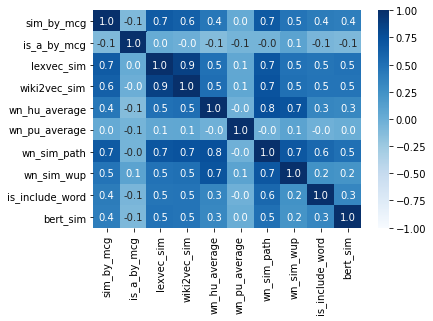

In [25]:
sokan(X_data)

In [26]:
X_data.shape

(447, 13)

In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#通常の特徴量ラベル
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]

#diffラベルのpca_ssモデル trainとtest arrを返す
def ss_pca(train,pca_n):
    scaler = StandardScaler()
    train=scaler.fit_transform(train)
    pca = PCA(n_components = pca_n)
    train = pca.fit_transform(train)
    return train

In [6]:
#str_arrをarrに変換
def convert_to_arr(vec_str):
    vec_arr = None
    for s in vec_str:
        if vec_arr is None:
            vec_arr =np.array(s[1:-1].split(", ")).astype("float32")
        else:
            vec_arr = np.block([[vec_arr],[np.array(s[1:-1].split(", ")).astype("float32")]])
    return vec_arr

In [15]:
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]
pca_di={"lexvec_diff":30,"wiki2vec_diff":30,"bert_diff":3}


#pca成分の生成
from sklearn.model_selection import StratifiedKFold,LeaveOneOut,KFold
from copy import deepcopy
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def learning(X_data,y):
    skf = StratifiedKFold(n_splits=5,random_state = 0)
    cm = None #混合配列
    v_acc = list()
    for train_idx, test_idx in skf.split(X_data,y):
        print("new epoc")

        #diff系以外をarrayに入れる 
        X = X_data.loc[:,X_normal_columns].values.astype("float64").astype("float64")


        # ベクトル系カラムをpcaする
        for column, n in pca_di.items():
            vec_arr = convert_to_arr(X_data.loc[:,column])
            pca_arr = ss_pca(vec_arr,n)
            X = np.concatenate([X, pca_arr], 1)


        #分割
        X_train = X[train_idx,:]
        X_test = X[test_idx,:]
        y_train = y[train_idx]
        y_test = y[test_idx]
        #print(X_train.shape)

        #LDA
        """
        lda = PCA()
        X_train = lda.fit_transform(X_train, y_train)
        X_test = lda.transform(X_test)
        """
        #XGBOOST
        #model = xgb.XGBClassifier(n_estimators=1500,max_depth=25,learning_rate=0.01)
        model = xgb.XGBClassifier(n_estimators=1500,max_depth=25,learning_rate=0.01)
        model.fit(X_train,y_train)
        
        #トレーニングスコアの算出
        #y_pred = model.predict(X_train)
        #t_acc.append(accuracy_score(y_pred, y_train))
        
        
        #検証スコアの算出
        y_pred = model.predict(X_test)
        #print(accuracy_score(y_test, y_pred))
        v_acc.append(accuracy_score(y_test, y_pred))
        
        cm_temp = confusion_matrix(y_pred, y_test)
        if cm is None:
            cm = cm_temp
            continue
        cm = cm + cm_temp
        
    #result
    import seaborn as sns
    print(v_acc)
    return v_acc

In [8]:


v_acc_li = list()
for i in range(200,480,20):
    v_acc = learning(X_data[0:i],y[0:i])
    v_acc_li.append(v_acc)

/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
new epoc
[0.5, 0.525, 0.375, 0.575, 0.5]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5454545454545454, 0.5454545454545454, 0.5, 0.5454545454545454, 0.5454545454545454]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5416666666666666, 0.375, 0.6041666666666666, 0.5833333333333334, 0.5208333333333334]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5576923076923077, 0.4423076923076923, 0.6923076923076923, 0.6153846153846154, 0.5961538461538461]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5892857142857143, 0.5, 0.6071428571428571, 0.5714285714285714, 0.6785714285714286]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5833333333333334, 0.5333333333333333, 0.6, 0.6166666666666667, 0.6666666666666666]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.609375, 0.59375, 0.609375, 0.671875, 0.625]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.5735294117647058, 0.5735294117647058, 0.6470588235294118, 0.6323529411764706, 0.6029411764705882]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6527777777777778, 0.625, 0.6666666666666666, 0.6388888888888888, 0.5833333333333334]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.618421052631579, 0.618421052631579, 0.7236842105263158, 0.75, 0.5131578947368421]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6, 0.6, 0.6375, 0.65, 0.6]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6666666666666666, 0.6428571428571429, 0.6309523809523809, 0.6785714285714286, 0.5476190476190477]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6477272727272727, 0.6590909090909091, 0.6931818181818182, 0.6590909090909091, 0.6136363636363636]
new epoc


/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


new epoc
new epoc
new epoc
new epoc
[0.6333333333333333, 0.6666666666666666, 0.6853932584269663, 0.651685393258427, 0.6741573033707865]


In [9]:
np.shape(v_acc_li)

(14, 5)

In [10]:
v_li = list()
for i in range(np.shape(v_acc_li)[0]):
    v_li.append(np.average(v_acc_li[i]))

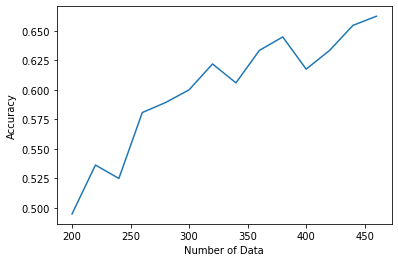

In [11]:
#学習曲線
def oresen(v_arr):
    x = np.array(range(200,480,20))
    plt.plot(x,v_arr,label="validation acc")
    plt.xlabel("Number of Data", fontsize=10) # x軸ラベル
    plt.ylabel("Accuracy", fontsize=10) # y軸ラベル
    plt.show
oresen(v_li)

In [12]:
data

,class_a,class_b,relation,type,title,source,sim_by_mcg,is_a_by_mcg,lexvec_sim,wiki2vec_sim,...,wn_sim_res,wn_sim_jcn,wn_sim_lin,has_same_word,is_include_word,bert_sim,lexvec_diff,wiki2vec_diff,bert_diff,relation_label
0,database,account_data,s2,analyse,hotel_system_2,me,3.534273,0.000000,0.405864,0.346269,...,0.596229,6.662405e-02,0.073590,0.0,0.0,0.975332,"[-0.036442, -0.018730499, -0.1123145, 0.012019...","[-0.18761757, -0.17080823, 0.24713495, -0.0983...","[0.13206336, 0.08027546, -0.01357232, 0.097821...",4
1,person,engineer,h2,sample,person_sample,uml_essence,0.512964,0.000000,0.157687,0.175974,...,2.333545,1.482017e-01,0.408868,0.0,0.0,0.950714,"[-0.033822004, 0.224855, 0.131755, 0.120946, 0...","[0.21936254, -0.4605171, -0.23989259, -0.05583...","[0.17486125, -0.12277912, 0.016683146, 0.00407...",1
2,room,hotel,s1,analyse,hotel_system_1,me,7.378811,0.000000,0.417745,0.509585,...,3.979366,1.717812e-01,0.577553,0.0,0.0,0.960316,"[0.053974997, -0.032351002, -0.045882, -0.0481...","[0.037616193, -0.10273511, 0.34396562, -0.0807...","[-0.027719725, -0.08040908, -0.08696404, -0.12...",3
3,faculty,user,h1,analyse,LibraryManagement,creately,11.385117,1.369863,0.154328,0.219077,...,0.000000,5.974787e-02,0.000000,0.0,0.0,0.928322,"[0.139304, -0.053229, 0.060622998, 0.20652899,...","[0.23291591, -0.18394254, 0.1913892, 0.2211001...","[0.062448516, 0.054628707, 0.18125094, 0.18381...",0
4,shopping_interface,shopping_basket,k,analyse,shopping_system_1,me,6.990688,0.000000,0.311641,0.375615,...,2.721860,2.500000e+299,0.263146,1.0,0.0,0.999606,"[0.032425, 0.098516494, -0.004016001, -0.02850...","[0.048278242, 0.048625052, 0.15299311, -0.0851...","[0.10029155, 0.1657108, -0.094794154, 0.032674...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,handle,bike,s1,sample,my_sample,my_samplebook,1.148567,0.000000,0.119371,0.220769,...,1.290026,6.910597e-02,0.151318,0.0,0.0,0.950408,"[-0.117424004, -0.055494003, -0.094823994, 0.0...","[0.2453539, 0.36670452, 0.3836474, 0.12040296,...","[0.09088758, 0.19013377, 0.006556943, -0.18327...",3
443,product,cart,s1,analyse,SGC,creately,1.694795,0.000000,0.219243,0.166445,...,2.305849,8.203741e-02,0.274485,0.0,0.0,0.915146,"[0.121877, 0.098452, -0.118272, -0.171242, -0....","[-0.009305939, -0.110634476, 0.39814562, 0.032...","[0.43876037, 0.09942454, 0.108824804, 0.090954...",3
444,school,teacher,s2,sample,web,web,1.364386,0.000000,0.575455,0.562681,...,0.000000,6.150305e-02,0.000000,0.0,0.0,0.984469,"[0.009508, -0.016981997, 0.0015270002, -0.0198...","[-0.03143651, 0.19860527, -0.58186024, -0.1225...","[0.02113305, 0.040494874, 0.061956123, 0.13061...",4
445,payment,order,k,analyse,monika,creately,10.558469,0.000000,0.298259,0.223843,...,0.596229,6.920586e-02,0.076234,0.0,0.0,0.971519,"[-0.040382, -0.084792, 0.007971998, -0.074694,...","[0.046864808, -0.053633504, -0.17013626, -0.03...","[4.0111203, 5.091501, -3.080672, 3.6644988, 6....",2


In [ ]:
label = ["whole","hanka1", "hanka2", "kanren", "syuyaku1", "syuyaku2"]
left=[1,2,3,4,5,6]
right=[0.68,0.81,0.83,0.61,0.67,0.53]
plt.ylabel("y axis")
plt.bar(left, height, tick_label=label, align="center")